Создадим кастомное окружение по образу и подобию тех, что лежат в ```gym/envs```

# 1. Проверка работоспособности нашего окружения

In [ ]:
import numpy as np
from math import *
import gym
from IPython.display import clear_output
from time import time

In [ ]:
from aircombat2d import Missile, Target, LineOfSight, AirCombat2D

In [ ]:
def target_autopilot(*args):
    t, = args
    if t < 4:
        beta = 20
    elif t < 15:
        beta = -40
    else:
        beta = 0

#     beta = -20

    return np.radians(beta)

In [ ]:
opts = {'los': {
            'r0': 15e3, 
            'chi0': np.radians(0)
        }, 
        'missile':{
            'initial_state': {
                'vel0': 400,
                'psi0': np.radians(180)
            },
            'energetics': {
                't_act': 5,
                'omega_act': 45
            },
            'aerodynamics': {
                'Ms': np.array([0.1, 0.3, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.05, 
                                1.1, 1.15, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.9, 4.3, 4.7]),
                'Cx0_arr': np.array([0.2958, 0.2998, 0.3078, 0.3198, 0.3234, 0.3273, 0.3314, 
                                     0.3358, 0.3404, 0.3453, 0.3504, 0.3558, 0.3614, 0.4426, 
                                     0.3598, 0.2885, 0.2376, 0.2009, 0.1741, 0.1533, 0.1377, 0.1255]),
                'Cya_arr': np.array([0.0571, 0.0577, 0.0591, 0.0615, 0.0623, 0.0633, 0.0643, 
                                     0.0655, 0.0671, 0.0708, 0.0794, 0.0814, 0.0802, 0.0664,
                                     0.0543, 0.0465, 0.042, 0.0387, 0.0358, 0.0331, 0.0312, 0.0291]),
                'Cyb_arr': np.array([0.0571, 0.0577, 0.0591, 0.0615, 0.0623, 0.0633, 0.0643, 
                                     0.0655, 0.0671, 0.0708, 0.0794, 0.0814, 0.0802, 0.0664, 
                                     0.0543, 0.0465, 0.042, 0.0387, 0.0358, 0.0331, 0.0312, 0.0291])
            }
        }, 
        'target': {
            'vel0': 400,
            'psi0': np.radians(0)            
        }}

In [ ]:
env = AirCombat2D(opts,altitude=15e3,target_autopilot=target_autopilot)
print("Action space:",env.action_space)
print("Observation space:", env.observation_space)

In [ ]:
env = gym.wrappers.TimeLimit(AirCombat2D(opts,altitude=15e3,target_autopilot=target_autopilot).unwrapped, max_episode_steps=500)
# проводим инициализацию и запоминаем начальное состояние
s = env.reset()

done = False
it = 1
start = time()

while not done:
    it += 1
    timeit = time()
    
    # выполняем действие, получаем s, r, done
    s, r, done, _ = env.step(1)

    # визуализируем окружение
    env.render()

#     print(f"Время выполнения {it} шага: {round(time() - timeit, 3)} с", end="\r")

clear_output(True)
print(f"Общее время: {round(time() - start, 3)} с;\nКол-во итераций: {it}.")

env.close()
if s[0] < 10:
    print("Успех!")
else:
    print("Промах!")

# 2. Создание DQN сети

In [1]:
import gym
import collections
import random
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

# если видеокарта доступна, то будем ее использовать
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("device:", device)

device: cpu


## 2.1 Определяем класс Q-Network

In [2]:
class QNetwork(nn.Module):
    def __init__(self, n_hid_n):
        """
        определение сети
        """
        super().__init__()
        
        self.fc1 = nn.Linear(9, n_hid_n)
        self.fc2 = nn.Linear(n_hid_n, n_hid_n)
        self.fc3 = nn.Linear(n_hid_n, 3)

    def forward(self, x):
        """
        определение графа вычислений
        :param x: вход/выход
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 2)
        else:
            return out.argmax().item()

## 2.2 Реализуем методы класса ReplayBuffer

In [3]:
class ReplayBuffer():

    def __init__(self, max_size):
        """
        создаем структуру для хранения данных
        """
        self.dq = deque(maxlen=max_size)
        
    def put(self, transition):
        """
        помещаем данные в replay buffer
        transition: (s, a, r, next_s, done_mask)
        """
        self.dq.append(transition)

    def sample(self, n):
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        # сэмплируем случайный батч и заполняем s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst
        for _ in range(n):
            index = random.randint(0, len(self.dq)-1)
            s_lst.append(self.dq[index][0])
            a_lst.append([self.dq[index][1]]) 
            r_lst.append([self.dq[index][2]]) 
            s_prime_lst.append(self.dq[index][3]) 
            done_mask_lst.append([self.dq[index][4]])

        return torch.tensor(np.array(s_lst), dtype=torch.float).to(device), \
               torch.tensor(np.array(a_lst), dtype=torch.int64).to(device), \
               torch.tensor(np.array(r_lst)).to(device), \
               torch.tensor(np.array(s_prime_lst), dtype=torch.float).to(device), \
               torch.tensor(np.array(done_mask_lst)).to(device)

    def __len__(self):
        return len(self.dq)

## 2.3 Реализуем функцию тренировки нашей сети

In [4]:
def train(q, q_target, replay_buffer, optimizer, batch_size, gamma, updates_number=20):
    for i in range(updates_number):
        # сэмплируем мини-батч из replay buffer'а
        s, a, r, s_prime, done_mask = replay_buffer.sample(batch_size)

        # получаем полезность, для выбранного действия q сети
        q_out = q(s)
        q_a = q_out.gather(1, a)

        # получаем значение max_q target сети и считаем значение target
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask

        # определяем loss функцию, для q!
        loss = F.smooth_l1_loss(q_a, target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## 2.4 Реализуем основную функцию, осуществляющую моделирование и обучение 

In [5]:
def run(q, 
        q_target,
        learning_rate, 
        gamma, 
        buffer_max_size, 
        batch_size, 
        target_update_interval,
        replay_buffer_start_size,
        filename,
        print_interval=20, 
        n_episodes=2000, 
        n_env_steps=1000, 
        render=False, 
        reward_history_plot=False,
        epsilon0=0.1, 
        coeff=0.005):

    # копируем веса q в target_q
    q_target.load_state_dict(q.state_dict())

    # создаем replay buffer
    replay_buffer = ReplayBuffer(max_size=buffer_max_size)

    score = 0.0
#     epi_indexes = []
#     rewards = []
#     distances = []
    
    infos = []
    multiplicator = 1

    # инициализируем оптимизатор, полученным lr
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    with open(filename, "w", newline="") as file:
        columns = ['episode', 'avg reward', 'terminal distance']
        writer = csv.DictWriter(file, fieldnames=columns, delimiter=";")
        writer.writeheader()

        for n_epi in range(n_episodes):
#             epi_indexes.append(n_epi)

    #         randint = random.randint(-20, 20)

            def target_autopilot(*args):
                t, = args
                if t < 4:
                    beta = 20
                elif t < 15:
                    beta = -40
                else:
                    beta = 0      
#                 beta = 0
                return np.radians(beta)

            # создаем окружение
            env = AirCombat2D(opts, altitude=15e3, target_autopilot=target_autopilot)
            max_state = env.observation_space.high
            min_state = env.observation_space.low

            # постепенно изменяем eps с 8% до 1%
            epsilon = max(0.01, epsilon0 - 0.01 * (n_epi * coeff))

            s = env.reset()
            s = normalize_state(s, max_state, min_state)

            # выполянем n_env_steps шагов в окружении и сохраняем, полученные данные
            sum_reward = 0

            for t in range(n_env_steps):

                # получаем действие, используя сеть q
                s_tensor = torch.from_numpy(s).float().to(device)

                a = q.sample_action(s_tensor, epsilon)

                # выполняем действие в окружении
                s_prime, r, done, info = env.step(a)
                distance = s_prime[0]

                s_prime = normalize_state(s_prime, max_state, min_state)
                r = r*multiplicator
                sum_reward += r

                # добавляем данные в replay buffer
                done_mask = 0.0 if done else 1.0

                # сжимаем вознаграждения и добавляем в replay buffer
                replay_buffer.put((s, a, r / 100.0, s_prime, done_mask))

                s = s_prime

                score += r

                if render:
                    env.render()

                if done:
                    avg_reward = sum_reward / t if t != 0 else sum_reward
#                     rewards.append(avg_reward)
#                     distances.append(distance)
                    infos.append(info)
                    
                    writer.writerow({columns[0]: n_epi, 
                                     columns[1]: avg_reward, 
                                     columns[2]: distance})
                    
                    if info == 'hit':
                        multiplicator += 0
                    else:
                        multiplicator = 1
                    break

            if len(replay_buffer) > replay_buffer_start_size:
                train(q, q_target, replay_buffer, optimizer, batch_size, gamma)

            if n_epi % target_update_interval == 0 and n_epi != 0:
                q_target.load_state_dict(q.state_dict())

            if n_epi % print_interval == 0 and n_epi != 0:
    #             clear_output(True)
                c = collections.Counter(infos)
                print("# of episode :{}, avg score : {:.1f}, buffer size : {}, epsilon : {:.1f}%, {}".format(
                    n_epi, score / print_interval, len(replay_buffer), epsilon * 100, c))
                infos = []
                score = 0.0
    env.close()
    
    return q, q_target, info

In [6]:
def normalize_state(state, max_state, min_state):
    return(state-min_state)/(max_state - min_state)

# 3. Определяем начальные параметры среды и подбираем гиперпараметры для обучения сети

In [7]:
from aircombat2d import Missile, Target, LineOfSight, AirCombat2D

In [8]:
opts = {'los': {
            'r0': 12e3, 
            'chi0': np.radians(0)
        }, 
        'missile':{
            'initial_state': {
                'vel0': 400,
                'psi0': np.radians(180)
            },
            'energetics': {
                't_act': 5,
                'omega_act': 45
            },
            'aerodynamics': {
                'Ms': np.array([0.1, 0.3, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.05, 
                                1.1, 1.15, 1.5, 1.9, 2.3, 2.7, 3.1, 3.5, 3.9, 4.3, 4.7]),
                'Cx0_arr': np.array([0.2958, 0.2998, 0.3078, 0.3198, 0.3234, 0.3273, 0.3314, 
                                     0.3358, 0.3404, 0.3453, 0.3504, 0.3558, 0.3614, 0.4426, 
                                     0.3598, 0.2885, 0.2376, 0.2009, 0.1741, 0.1533, 0.1377, 0.1255]) * 1.5,
                'Cya_arr': np.array([0.0571, 0.0577, 0.0591, 0.0615, 0.0623, 0.0633, 0.0643, 
                                     0.0655, 0.0671, 0.0708, 0.0794, 0.0814, 0.0802, 0.0664,
                                     0.0543, 0.0465, 0.042, 0.0387, 0.0358, 0.0331, 0.0312, 0.0291]),
                'Cyb_arr': np.array([0.0571, 0.0577, 0.0591, 0.0615, 0.0623, 0.0633, 0.0643, 
                                     0.0655, 0.0671, 0.0708, 0.0794, 0.0814, 0.0802, 0.0664, 
                                     0.0543, 0.0465, 0.042, 0.0387, 0.0358, 0.0331, 0.0312, 0.0291])
            }
        }, 
        'target': {
            'vel0': 300,
            'psi0': np.radians(0)            
        }}

In [9]:
FILENAME = "log.csv"

q = QNetwork(128).to(device)
q_target = q
epi_indexes, rewards, distances = [], [], []
q_new, q_target_new, info = run(
    q,                          
    q_target,                        
    learning_rate=0.0001,
    gamma=0.995,
    buffer_max_size=1000000,
    batch_size=64,
    target_update_interval=10,
    replay_buffer_start_size=90000,
    filename=FILENAME,
    print_interval=100,
    n_episodes=5000,
    n_env_steps=500,
    epsilon0=0.1, 
    coeff=0.005
)

# of episode :100, avg score : 27.5, buffer size : 8235, epsilon : 9.5%, Counter({'out of range': 101})
# of episode :200, avg score : 27.0, buffer size : 16372, epsilon : 9.0%, Counter({'out of range': 100})
# of episode :300, avg score : 27.4, buffer size : 24543, epsilon : 8.5%, Counter({'out of range': 100})
# of episode :400, avg score : 27.0, buffer size : 32674, epsilon : 8.0%, Counter({'out of range': 100})
# of episode :500, avg score : 26.5, buffer size : 40747, epsilon : 7.5%, Counter({'out of range': 100})
# of episode :600, avg score : 26.7, buffer size : 48844, epsilon : 7.0%, Counter({'out of range': 100})
# of episode :700, avg score : 26.6, buffer size : 56926, epsilon : 6.5%, Counter({'out of range': 100})
# of episode :800, avg score : 26.7, buffer size : 65016, epsilon : 6.0%, Counter({'out of range': 100})
# of episode :900, avg score : 26.7, buffer size : 73105, epsilon : 5.5%, Counter({'out of range': 100})
# of episode :1000, avg score : 26.5, buffer size : 8117

In [10]:
torch.save(q_new, 'q2.pt')
torch.save(q_target_new, 'q_target2.pt')

In [ ]:
q_new = torch.load('q.pt')
q_target_new = torch.load('q_target.pt')

In [11]:
FILENAME = "log.csv"
rewards, distances, epi_indexes = [], [], []
with open(FILENAME, "r", newline="") as file:  
    reader = csv.DictReader(file, delimiter=";")
    for row in reader:
        epi_indexes.append(int(row['episode']))
        rewards.append(float(row['avg reward']))
        distances.append(float(row['terminal distance']))
r = np.array(rewards)
d = np.array(distances)
x = np.array(epi_indexes)

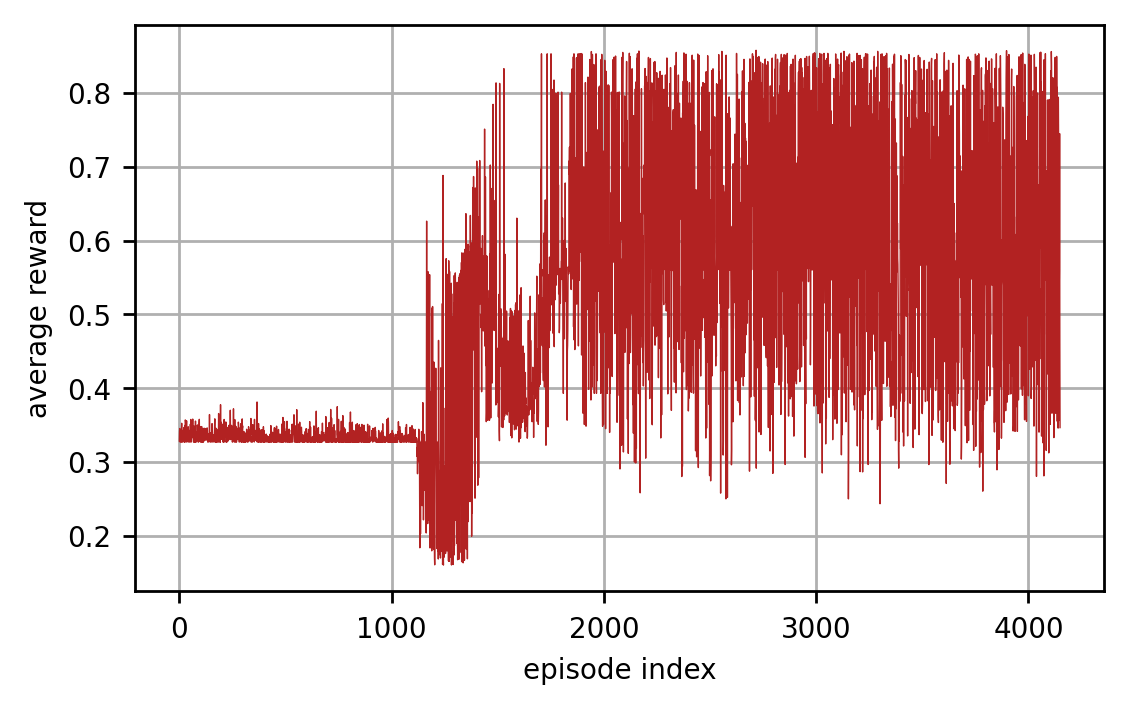

In [12]:
h = 1
cut = 850
fontsize = 8
fig, ax = plt.subplots(figsize=(5, 3), dpi=250)
plt.plot(x[:-cut:h], r[:-cut:h], lw=0.4, c='firebrick', alpha=1.)
plt.xlabel('episode index', fontsize=fontsize)
plt.ylabel('average reward', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.grid()
plt.show()

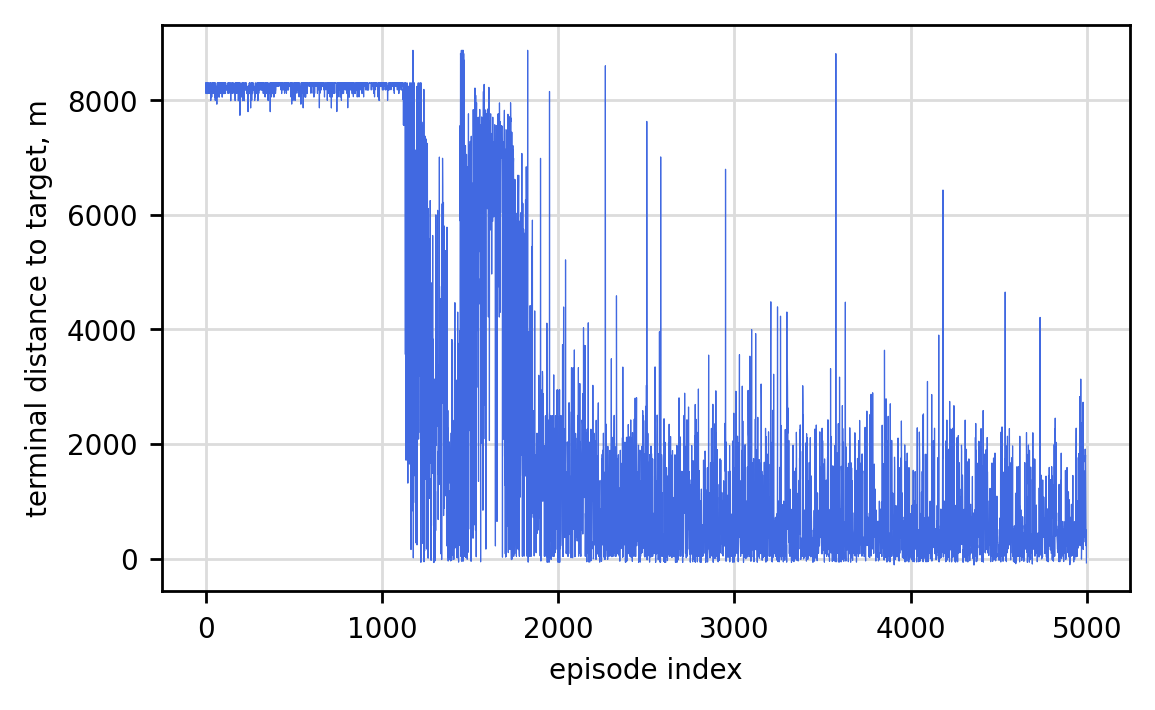

In [13]:
h = 1
cut = 1
fontsize = 8
fig, ax = plt.subplots(figsize=(5, 3), dpi=250)
plt.plot(x[:-cut:h], d[:-cut:h], lw=0.35, c='royalblue', alpha=1.)
plt.xlabel('episode index', fontsize=fontsize)
plt.ylabel('terminal distance to target, m', fontsize=fontsize, rotation=90)
plt.tick_params(labelsize=fontsize)

# ax.yaxis.set_label_coords(-.15, .4)

plt.grid(c='gainsboro')
plt.show()

In [17]:
FILENAME = "log_new2.csv"
run(
    q_new,                          
    q_target_new,                        
    learning_rate=0.0001,
    gamma=0.995,
    buffer_max_size=1000000,
    batch_size=64,
    target_update_interval=10,
    replay_buffer_start_size=90000,
    filename=FILENAME,
    print_interval=1,
    n_episodes=10,
    n_env_steps=500,
    epsilon0=0.1, 
    coeff=0.005,
    render=True
)

KeyboardInterrupt: 

In [ ]:
# FILENAME = "log_new1.csv"
# run(
#     q_new,                          
#     q_target_new,                        
#     learning_rate=0.0001,
#     gamma=0.99,
#     buffer_max_size=1000000,
#     batch_size=32,
#     target_update_interval=10,
#     replay_buffer_start_size=90000,
#     filename=FILENAME,
#     print_interval=1,
#     n_episodes=1,
#     n_env_steps=500,
#     epsilon0=0.1, 
#     coeff=0.002,
#     render=True
# )

In [ ]:
def target_autopilot(*args):
    t, = args
    if t < 2:
        beta = 0
    elif t < 6:
        beta = 20
    elif t < 17:
        beta = -20
    else:
        beta = 0        
#    beta = 0
    return np.radians(beta)

env = AirCombat2D(opts, altitude=15e3, target_autopilot=target_autopilot)
print("Action space:",env.action_space)
print("Observation space:", env.observation_space.low)

In [ ]:
env = gym.wrappers.TimeLimit(AirCombat2D(opts,altitude=15e3,target_autopilot=target_autopilot).unwrapped, max_episode_steps=500)
# проводим инициализацию и запоминаем начальное состояние
s = env.reset()

done = False

while not done:
    
    s_tensor = torch.from_numpy(s).float().to(device)
    
    a = q_new.sample_action(s_tensor, 0.01)
    
    # выполняем действие, получаем s, r, done
    s, r, done, info = env.step(a)
    
    # визуализируем окружение
#     env.render()

#     print(f"Время выполнения {it} шага: {round(time() - timeit, 3)} с", end="\r")

clear_output(True)

env.close()
if s[0] < 10:
    print("Успех!")
else:
    print(f"Не успех: {info}")